# Word frequencies in digitised journals

This notebook uses word frequency to explore the [OCRd texts harvested](Download-text-for-all-digitised-journals.ipynb) from Trove's digitised journals. More documentation coming...

In [1]:
import re
import tarfile
import zipfile
from io import BytesIO
import pandas as pd
import requests
from tqdm.auto import tqdm
import altair as alt
import os
from pathlib import Path
import ipywidgets as widgets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

## Select a journal

Create a dropdown widget to select a digitised journal. The cells below will use this widget to get the value of the currently selected journal.

In [2]:
# Load details of digitised journals from CSV
df_journals = pd.read_csv('digital-journals-with-text.csv').sort_values(by='title')
journal_list = [(f"{j['title']} ({j['issues_with_text']} issues)", j['directory']) for j in df_journals[['title', 'directory', 'issues_with_text']].to_dict('records')]
journals = widgets.Dropdown(options=journal_list, disabled=False)
display(journals)

Dropdown(options=(('"Coo-ee!" (Bishops Knoll Hospital (Bristol, England)) (12 issues)', 'coo-ee-bishops-knoll-…

## Download all the issues of the journal

In [3]:
def get_docs_path(journal):
    path = os.path.join('downloads', journal, 'texts')
    docs_path = [p for p in sorted(Path(path).glob('*.txt'))]
    return docs_path

def download_journal(journal):
    path = os.path.join('downloads', journal)
    os.makedirs(path, exist_ok=True)
    params = {
        'path': f'/{journal}/texts'
    }
    response = requests.get('https://cloudstor.aarnet.edu.au/plus/s/QOmnqpGQCNCSC2h/download', params=params)
    zipped = zipfile.ZipFile(BytesIO(response.content))
    zipped.extractall(path)
    print(f'{len(get_docs_path(journal))} issues downloaded')

In [4]:
download_journal(journals.value)

12 issues downloaded


## Calculate word frequencies

In [5]:
def get_docs(journal):
    docs_path = get_docs_path(journal)
    for p in docs_path:
        yield p.read_text(encoding='utf-8').strip()

def get_file_names(journal):
    return [p.stem for p in get_docs_path(journal)]

In [6]:
# Remove numbers
# preprocessor = lambda x: re.sub(r'\b(\w*\d\w*)\b', 'NUM', x.lower())
vectorizer = CountVectorizer(
    stop_words='english', 
    ngram_range=(1,1), 
    token_pattern='[a-z]{3,}', 
    lowercase=True, 
    max_features=100000
)

X_freq = np.asarray(vectorizer.fit_transform(get_docs(journals.value)).todense())
df_freq = pd.DataFrame(X_freq, columns=vectorizer.get_feature_names(), index=get_file_names(journals.value))

In [7]:
# Save to CSV
df_freq.to_csv(f'{journals.value}-word-frequencies.csv')

In [8]:
np.save(f'{journals.value}-word-frequencies.npy', X_freq)

In [9]:
df_freq.shape

(12, 15893)

In [10]:
totals = df_freq.sum().to_frame().reset_index()

In [11]:
totals.columns = ['word', 'count']

In [12]:
totals.loc[totals['count'] > 180].shape

(33, 2)

In [13]:
totals

,word,count
0,abandoned,3
1,abate,2
2,abberration,1
3,abberrations,1
4,abbey,9
...,...,...
15888,zoo,8
15889,zoological,1
15890,zoologist,1
15891,zur,1


## Most frequent words in the journal

Change the number as you wish.

In [14]:
df_freq.sum().nlargest(20)

pte           927
bristol       499
time          432
day           399
private       387
good          371
hospital      352
old           351
coo           333
man           319
men           314
war           307
great         295
said          291
just          258
knoll         254
little        249
like          247
australian    241
bishop        226
dtype: int64

## Frequency of a specific word

In [15]:
word = 'chinese'

In [16]:
# If the word's not in the index you'll get a KeyError -- don't worry about it, just try another word!!
df_freq[word].sum()

KeyError: 'chinese'

Find the issue that this word occurs in most frequently.

In [105]:
df_freq[word].idxmax()

'the-bulletin-vol-9-no-0428-14-apr-1888-nla.obj-706788911'

## Most frequent words per issue

Get the most frequent words for each issue of the journal. Set `num_words` to the number of words you want to show.

In [17]:
# The number of words you want to show
num_words = 20
top_words = pd.DataFrame({n: df_freq.T[col].nlargest(num_words).index.tolist() for n, col in enumerate(df_freq.T)}).T
top_words.index = get_file_names(journals.value)
top_words.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
coo-ee-the-journal-of-the-bishops-knoll-hospital-b-issue-vol-i-no-10-bristol-august-24th-nla.obj-15922909,pte,bristol,hospital,day,time,war,milk,coo,little,great,good,private,australian,new,patients,home,old,work,boys,given
coo-ee-the-journal-of-the-bishops-knoll-hospital-b-issue-volume-1-no-12-nla.obj-9878439,pte,private,good,hospital,knoll,time,bishop,bristol,round,men,say,man,western,right,war,australian,day,great,half,ward
coo-ee-the-journal-of-the-bishops-knoll-hospital-b-issue-volume-1-number-9-nla.obj-9139951,pte,just,time,old,private,war,hospital,said,good,bristol,day,man,way,coo,men,know,long,did,knoll,little
coo-ee-the-journal-of-the-bishops-knoll-hospital-b-volume-1-number-1-nla.obj-8447243,pte,bristol,coo,war,knoll,old,time,bishop,day,hospital,great,australia,patients,came,days,long,plain,south,way,like
coo-ee-the-journal-of-the-bishops-knoll-hospital-b-volume-1-number-11-nla.obj-9557231,pte,private,bristol,coo,man,men,hospital,day,good,miss,old,time,patients,just,plain,great,round,australian,smith,ward


Get the top words for a specific issue.

In [18]:
top_words.loc[top_words.index.str.contains('nla.obj-774168904')]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


## Track word frequencies over time

In [19]:
def extract_year(name):
    '''
    Try to extract the year from the filename.
    '''
    try:
        years = re.findall(r'-((?:18|19|20)\d{2})-', name)
        year = int(years[-1])
    except IndexError:
        year = 0
        print(f'YEAR NOT FOUND: {name}')
    return year
    
df_freq['year'] = df_freq.apply(lambda x: extract_year(x.name), axis=1)

YEAR NOT FOUND: coo-ee-the-journal-of-the-bishops-knoll-hospital-b-issue-vol-i-no-10-bristol-august-24th-nla.obj-15922909
YEAR NOT FOUND: coo-ee-the-journal-of-the-bishops-knoll-hospital-b-issue-volume-1-no-12-nla.obj-9878439
YEAR NOT FOUND: coo-ee-the-journal-of-the-bishops-knoll-hospital-b-issue-volume-1-number-9-nla.obj-9139951
YEAR NOT FOUND: coo-ee-the-journal-of-the-bishops-knoll-hospital-b-volume-1-number-1-nla.obj-8447243
YEAR NOT FOUND: coo-ee-the-journal-of-the-bishops-knoll-hospital-b-volume-1-number-11-nla.obj-9557231
YEAR NOT FOUND: coo-ee-the-journal-of-the-bishops-knoll-hospital-b-volume-1-number-2-nla.obj-8452230
YEAR NOT FOUND: coo-ee-the-journal-of-the-bishops-knoll-hospital-b-volume-1-number-3-nla.obj-8458012
YEAR NOT FOUND: coo-ee-the-journal-of-the-bishops-knoll-hospital-b-volume-1-number-4-nla.obj-8465575
YEAR NOT FOUND: coo-ee-the-journal-of-the-bishops-knoll-hospital-b-volume-1-number-5-nla.obj-8469716
YEAR NOT FOUND: coo-ee-the-journal-of-the-bishops-knoll-hosp

In [109]:
# Top words per year
year_groups = df_freq.groupby(by='year')
year_group_totals = year_groups.sum()
df_years = pd.DataFrame({n: year_group_totals.T[col].nlargest(10).index.tolist() for n, col in enumerate(year_group_totals.T)}).T
df_years.index = [name for name, _ in year_groups]
df_years.head()

,0,1,2,3,4,5,6,7,8,9
0,said,man,sydney,street,old,like,time,new,good,little
1880,sydney,street,new,man,good,george,time,great,said,melbourne
1881,street,sydney,new,man,day,good,time,great,said,best
1882,street,sydney,man,new,tho,time,day,good,old,said
1883,street,sydney,man,new,time,tho,day,good,old,little


In [112]:
year_group_totals.to_csv('words_by_year.csv')

In [111]:
year_group_totals['total_words'] = year_group_totals.sum(axis=1)

,aa,aaa,aaaa,aac,aachen,aad,aae,aah,aai,aaid,...,zuyder,zv,zw,zwar,zweig,zx,zy,zz,zzz,total_words
year,,,,,,,,,,,,,,,,,,,,,
0,19,2,0,0,0,1,0,0,0,0,...,0,1,1,0,0,3,2,4,0,564704
1880,27,0,0,1,0,9,0,0,0,1,...,0,1,0,0,0,0,0,1,0,942178
1881,53,3,0,0,0,36,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1319179
1882,225,1,2,3,0,130,1,1,1,5,...,0,0,0,0,0,0,2,0,0,1365659
1883,196,6,0,1,0,107,2,3,3,4,...,0,0,2,0,0,0,0,3,0,1625329


In [22]:
def words_by_year(df, words):
    df_words = pd.DataFrame()
    for word in words:
        try:
            df_word = df.groupby(by='year').sum()[word].to_frame().reset_index().rename({word: 'count'}, axis=1)
        except KeyError:
            print(f"'{word}' not found")
        else:
            df_word['word'] = word
            df_words = df_words.append(df_word, ignore_index=True)
    return df_words

Make a list of words that we want to compare.

In [35]:
words = ['nation', 'chinese', 'republic', 'worker', 'unions', 'union', 'labor']

Get the data for those words.

In [36]:
df_words = words_by_year(df_freq, words)

Create a faceted line chart.

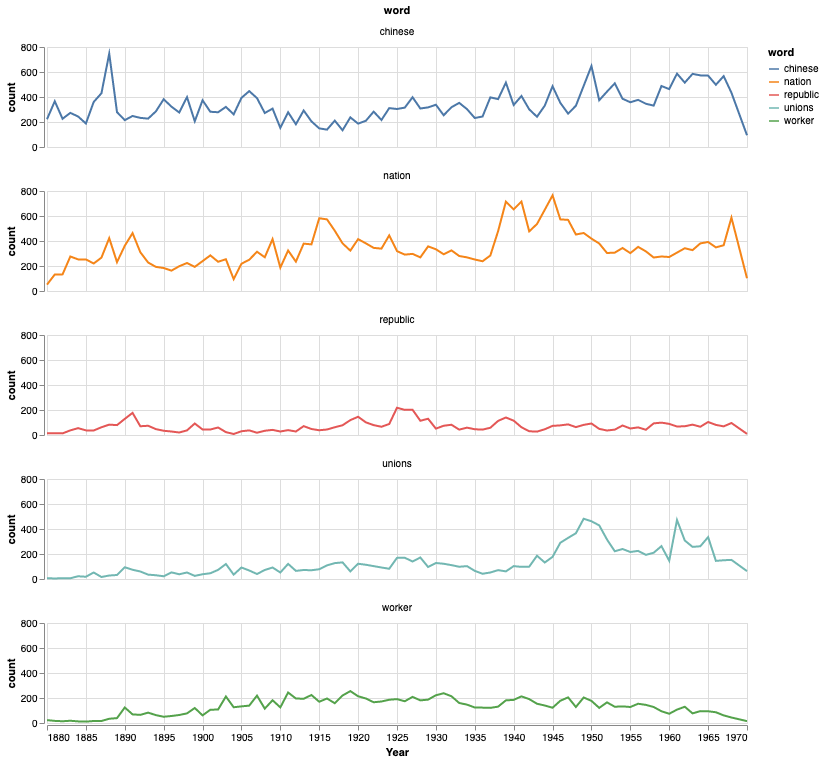

In [33]:
alt.Chart(df_words.loc[df_words['year'] > 0]).mark_line().encode(
    x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year')),
    y='count:Q',
    color='word:N',
    facet='word:N'
).properties(width=700, height=100, columns=1)

Or perhaps you prefer bubblelines.

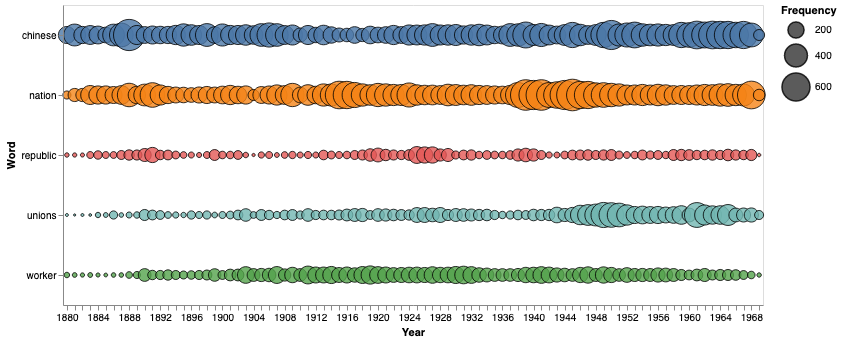

In [34]:
# Create a chart
alt.Chart(df_words.loc[df_words['year'] > 0]).mark_circle(
    
    # Style the circles
    opacity=0.8,
    stroke='black',
    strokeWidth=1
).encode(
    
    # Year on the X axis
    x=alt.X('year:O', axis=alt.Axis(format='c', title='Year', labelAngle=0)),
    
    # Object type on the Y axis
    y=alt.Y('word:N', title='Word'),
    
    # Size of the circles represents the number of objects
    size=alt.Size('count:Q',
        scale=alt.Scale(range=[0, 1000]),
        legend=alt.Legend(title='Frequency')
    ),
    
    # Color the circles by object type
    color=alt.Color('word:N', legend=None),
    
    # More details on hover
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('year:O', title='Year'), alt.Tooltip('count:Q', title='Frequency', format=',')]
).properties(
    width=700,
    height=300
)